# XN Project - Classification and Segmentation of MRI Images
**Group Members:** Brandon Archbald, Emily Nason, Jaynam Shah

**Overview:** The Zeta Surgical company was started by a team of Harvard graduates and academics. The
mission is to democratize access to accurate, safe and fast image guidance, to unlock the use of
image guidance directly at the point of care, and to enable new treatments in cases such as
emergencies and bedside procedures. For this project, the company has provided us with a
dataset consisting of various brain CT scan slices, each of which has a hemorrhage (bleeding)
within it. The hemorrhages have been labeled in some of the images. These hemorrhages are
divided into different types: intraparenchymal, intraventricular, subarachnoid, subdural, epidural,
and category for images with multiple sources of bleeding. Students will use techniques in
machine learning, computer vision, user interface, and data analytics to do the classification,
regression, and segmentation of these CT images.


## Phase 1 - Data Cleaning

This section will focus on the cleaning and organiztion of the data. Once we have a solid dataset for which images we want to use then impleneting the model on the dataset will become much easier. We intend to:
- Remove any NA or Missing Values from the dataset
- Filter on only images which we know are already labelled
- Organize the the files into one primary dataset with corresponding categorical labels 
- Potentially try and downsize the data or use some sort of information embedding like PCA 

In [9]:
#Importing Modules used for the data cleaning
import pandas as pd
import numpy as np
import os
import random
import matplotlib.pyplot as plt
import matplotlib
from sklearn.model_selection import train_test_split
from keras.utils import np_utils
from sklearn import svm
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score,confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
from keras import layers
from keras.layers.core import Dense,Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import shutil
import tensorflow as tf
from sklearn import metrics

In [32]:
'''
For this file I am using OS to access local files on my hard disk with labelled folders to easily access the raw data files. 
Some file location names may need to be changed if this is run on a differnt pc but it should be a matter of changing file locations
'''
#Initialize the path for the files to be pulled from and also the desired columns
path = os.getcwd() + "\\Segmented Images"
file_list = os.listdir(path)
column_names = ["Origin","Labeling State","All Labels","Correct Label","Type"]
df_raw = pd.DataFrame(columns=column_names)
file_list

#This Loop opens each file in the directory and creates a combined dataframe with the file names and type for each segmented file
for file in file_list:
    cols = column_names[:4]
    df_temp = pd.read_csv(path + "\\" + file)
    df_temp = df_temp[cols]
    df_temp["Type"] = file.strip().split()[0].replace("Results_","")
    df_temp
    df_raw = df_raw.append(df_temp)

#Creating a df to export so we can comb the results by eye for any glaring abnormalities (This Code was used but is now useless)

# df_exp = df[df["Labeling State"] == "Labeled"].dropna().reset_index().drop(['index'],axis = 1)
# df_exp.to_excel("Patrially Cleaned Data.xlsx", index = False)


#Remove abnormalilites from the Correct Label section
df = df_raw[df_raw["Labeling State"] == "Labeled"].dropna().reset_index().drop(['index'],axis = 1)
df['Valid'] = df['Correct Label'].apply(lambda x: 1 if "x" in x else 0)
df = df[df.Valid == 1].reset_index().drop(["index","Valid"],axis = 1)
df


,Origin,Labeling State,All Labels,Correct Label,Type
0,ID_004c4b319.jpg,Labeled,"['[{""x"": 0.40818718, ""y"": 0.8623607}, {""x"": 0....","[[{'x': 0.537109375, 'y': 0.89453125}, {'x': 0...",Epidural
1,ID_02e2d273d.jpg,Labeled,"['[{""x"": 0.35205495, ""y"": 0.34680602}, {""x"": 0...","[[{'x': 0.46484375, 'y': 0.357421875}, {'x': 0...",Epidural
2,ID_03c6a01ca.jpg,Labeled,"['[{""x"": 0.55595756, ""y"": 0.7275065}, {""x"": 0....","[[{'x': 0.55078125, 'y': 0.7265625}, {'x': 0.5...",Epidural
3,ID_03c6a01ca.jpg,Labeled,"['[{""x"": 0.55595756, ""y"": 0.7275065}, {""x"": 0....","[[{'x': 0.55078125, 'y': 0.7265625}, {'x': 0.5...",Epidural
4,ID_045196c9f.jpg,Labeled,"['[{""x"": 0.591917, ""y"": 0.7922052}, {""x"": 0.60...","[[{'x': 0.591796875, 'y': 0.791015625}, {'x': ...",Epidural
...,...,...,...,...,...
1974,ID_ff1e93267.jpg,Labeled,"['[{""x"": 0.25159726, ""y"": 0.24648584}, {""x"": 0...","[[{'x': 0.685546875, 'y': 0.43359375}, {'x': 0...",Subdural
1975,ID_ff1e93267.jpg,Labeled,"['[{""x"": 0.25159726, ""y"": 0.24648584}, {""x"": 0...","[[{'x': 0.685546875, 'y': 0.43359375}, {'x': 0...",Subdural
1976,ID_ff2f3dbb7.jpg,Labeled,"['[{""x"": 0.70854944, ""y"": 0.6837957}, {""x"": 0....","[[{'x': 0.70703125, 'y': 0.67578125}, {'x': 0....",Subdural
1977,ID_04ab5246e.jpg,Labeled,"['[{""x"": 0.56073856, ""y"": 0.6705539}, {""x"": 0....","[[{'x': 0.560546875, 'y': 0.669921875}, {'x': ...",Subdural


In [33]:
#Assemble a random sample of normal images to to add to the training list
N = 5000
path_n = os.getcwd() + "\\renders\\normal\\max_contrast_window"
file_list_n = os.listdir(path_n)

random.seed(123) #Keeps random state the same while we are testing 
normal_files = random.sample(file_list_n,k = N)

#Format df same as the other data frame so we can easily append it
df_normal = pd.DataFrame(normal_files,columns= ['Origin'])
df_normal["Labeling State"] = "None"
df_normal["All Labels"] = "None"
df_normal["Correct Label"] = "None"
df_normal["Type"] = "Normal"

#Append this Normal File df to the original df
df = df.append(df_normal).reset_index().drop(["index"],axis = 1)
df["Type Encoded"] = df["Type"].astype('category').cat.codes
df['File Location'] = os.getcwd() + "\\renders"+"\\"+df["Type"].str.lower()+"\\max_contrast_window\\" + df["Origin"]
df = df[df['Origin']!='.ipynb_checkpoints']
df = df.reset_index().drop(["index"],axis = 1)
df

,Origin,Labeling State,All Labels,Correct Label,Type,Type Encoded,File Location
0,ID_004c4b319.jpg,Labeled,"['[{""x"": 0.40818718, ""y"": 0.8623607}, {""x"": 0....","[[{'x': 0.537109375, 'y': 0.89453125}, {'x': 0...",Epidural,0,c:\Users\Quick\Documents\School\Machine Learni...
1,ID_02e2d273d.jpg,Labeled,"['[{""x"": 0.35205495, ""y"": 0.34680602}, {""x"": 0...","[[{'x': 0.46484375, 'y': 0.357421875}, {'x': 0...",Epidural,0,c:\Users\Quick\Documents\School\Machine Learni...
2,ID_03c6a01ca.jpg,Labeled,"['[{""x"": 0.55595756, ""y"": 0.7275065}, {""x"": 0....","[[{'x': 0.55078125, 'y': 0.7265625}, {'x': 0.5...",Epidural,0,c:\Users\Quick\Documents\School\Machine Learni...
3,ID_03c6a01ca.jpg,Labeled,"['[{""x"": 0.55595756, ""y"": 0.7275065}, {""x"": 0....","[[{'x': 0.55078125, 'y': 0.7265625}, {'x': 0.5...",Epidural,0,c:\Users\Quick\Documents\School\Machine Learni...
4,ID_045196c9f.jpg,Labeled,"['[{""x"": 0.591917, ""y"": 0.7922052}, {""x"": 0.60...","[[{'x': 0.591796875, 'y': 0.791015625}, {'x': ...",Epidural,0,c:\Users\Quick\Documents\School\Machine Learni...
...,...,...,...,...,...,...,...
6974,ID_009e9ba53.jpg,None,None,None,Normal,3,c:\Users\Quick\Documents\School\Machine Learni...
6975,ID_0260aad1d.jpg,None,None,None,Normal,3,c:\Users\Quick\Documents\School\Machine Learni...
6976,ID_004ef9065.jpg,None,None,None,Normal,3,c:\Users\Quick\Documents\School\Machine Learni...
6977,ID_00a9c101e.jpg,None,None,None,Normal,3,c:\Users\Quick\Documents\School\Machine Learni...


In [34]:
df.Type.value_counts()

Normal              5000
Intraparenchymal     574
Multi                427
Subarachnoid         387
Epidural             302
Subdural             289
Name: Type, dtype: int64

## Part 2 - Implementing Basic Models

### SVM Implementation

__Description:__ In this section we will:

1. Load in the images into arrays
2. Downsample the images  
3. Split the data into train-test
4. Implement SVM Model

In [35]:
DS = 16            # Downsample rate, must be a multiple of 30976

if 262144/DS % 1 > 0:
    print("Downsample rate is not a multiple of 30976")
    DS = 1
    im_size = 262144 #32768 #30976
else:
    im_size = int(262144/DS)

data = np.zeros([df.shape[0], im_size])


#list of indices with wrong img shapes - remove from original df and from img df
wrong_list = []

for i, file_name in enumerate(df['File Location']):
    try:
        img = np.mean(matplotlib.image.imread(file_name),axis=2)#.reshape(-1)
        if img.shape[0] == 512:
            img = (img.reshape(-1))/255
            data[i,:] = img[::DS]            # Downsample the image
        else:
            wrong_list.append(i)
    except:
        wrong_list.append(i)

In [36]:
data2 = np.delete(data, wrong_list, 0)
image_df = pd.DataFrame(data2)
df2 = df.drop(wrong_list, axis=0)

In [39]:
x_train, x_test, y_train, y_test = train_test_split(image_df, df2["Type"], test_size=0.2, random_state=0)

In [8]:
param_grid={'C':[0.1,1,10],'gamma':[0.0001,0.001],'kernel':['rbf','poly']}
svc=svm.SVC()
model=GridSearchCV(svc,param_grid)

print('Splitted Successfully')
model.fit(x_train,y_train)
print('The Model is trained well with the given images')
# model.best_params_ contains the best parameters obtained from GridSearchCV

Splitted Successfully
The Model is trained well with the given images


In [9]:
model.best_params_

# {'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}

{'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}

In [40]:
model=svm.SVC(C = 10, gamma= .001, kernel="rbf")
# model=GridSearchCV(svc,param_grid)

print('Splitted Successfully')
model.fit(x_train,y_train)
print('The Model is trained well with the given images')
# model.best_params_ contains the best parameters obtained from GridSearchCV

Splitted Successfully
The Model is trained well with the given images


In [41]:
y_pred=model.predict(x_test)
print("The predicted Data is :")
print(y_pred)
print("The actual data is:")
print(np.array(y_test))
print(f"The model is {accuracy_score(y_pred,y_test)*100}% accurate")

# The model is 77.56% accurate on first run
# The model is 87.33% accurate on with best parameters


The predicted Data is :
['Normal' 'Normal' 'Normal' ... 'Normal' 'Normal' 'Normal']
The actual data is:
['Normal' 'Normal' 'Normal' ... 'Normal' 'Normal' 'Subdural']
The model is 85.88825214899714% accurate


In [59]:
df_dict = df.groupby(['Type','Type Encoded']).size().reset_index()
df_dict

,Type,Type Encoded,0
0,Epidural,0,302
1,Intraparenchymal,1,574
2,Multi,2,427
3,Normal,3,5000
4,Subarachnoid,4,387
5,Subdural,5,289


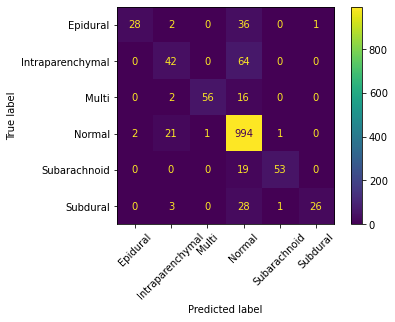

In [64]:

confusion_matrix = metrics.confusion_matrix(y_test, y_pred)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix,display_labels=df_dict["Type"])

cm_display.plot()
plt.xticks(rotation=45)
plt.show()

## Part 3 - Implementing Pretrained Models

__Description:__ In this section we will:

1. Assemble a new directory that is filtered and can be used for train test splits
2. Split data for Train and Test 
3. Implement ResNet50
4. Implement EfficientNet (Possibly)

In [65]:
import matplotlib.image as Img
#Filter down the images that aren't the right size
df_dir  = df.copy(deep=True)
#df_dir["Size"] = df_dir["File Location"].apply(lambda x:Img.imread(x).shape) 

l = []

for i, file_name in enumerate(df_dir['File Location']):
    try:
        img = Img.imread(file_name)
        l.append(img.shape)
    except:
        l.append("Failed")

df_dir["Size"] = l 


In [66]:
#Assemble a new directory with the files that is suffucient for (tf.keras.preprocessing.image_dataset_from_directory) 
df_dir = df_dir[df_dir["Size"] ==(512, 512, 3)].reset_index().drop('index',axis = 1)
df_dir['New File Location'] = os.getcwd() + "\\ResNet50"+"\\"+df["Type"].str.lower()+"\\" + df["Origin"]
df_dir

for i, file_name in enumerate(df_dir['File Location']):
    original = str(file_name)
    target = str(df_dir.iloc[i]["New File Location"])
    try:
        shutil.copyfile(original, target)
    except:
        path = os.getcwd() + "\\ResNet50"+"\\"+df_dir.iloc[i]["Type"].lower()
        print(path)
        os.mkdir(path)
        shutil.copyfile(original, target)


c:\Users\Quick\Documents\School\Machine Learning and Stat Theory\Project\ResNet50\multi


### ResNet50 Implementation

In [67]:
#Split the data for training and validation

PATH = os.getcwd() + "\\ResNet50"

img_height,img_width=512,512
batch_size=32
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  PATH,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)


val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  PATH,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

#Continue to Create the model 

Found 6480 files belonging to 7 classes.
Using 5184 files for training.
Found 6480 files belonging to 7 classes.
Using 1296 files for validation.


In [72]:
resnet_model = Sequential()

pretrained_model= tf.keras.applications.ResNet50(include_top=False,
                   input_shape=(512,512,3),
                   pooling='avg',classes=7,
                   weights='imagenet')
for layer in pretrained_model.layers:
        layer.trainable=False

resnet_model.add(pretrained_model)

In [73]:
resnet_model.add(Flatten())
resnet_model.add(Dense(512, activation='relu'))
resnet_model.add(Dense(7, activation='softmax'))

In [74]:
resnet_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 2048)              23587712  
_________________________________________________________________
flatten_1 (Flatten)          (None, 2048)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               1049088   
_________________________________________________________________
dense_3 (Dense)              (None, 7)                 3591      
Total params: 24,640,391
Trainable params: 1,052,679
Non-trainable params: 23,587,712
_________________________________________________________________


In [75]:
resnet_model.compile(optimizer=Adam(lr=0.001),loss='sparse_categorical_crossentropy',metrics=['accuracy'])

history = resnet_model.fit(train_ds, validation_data=val_ds, epochs=5)

Epoch 1/5
162/162 [==============================] - 1554s 10s/step - loss: 0.9329 - accuracy: 0.7658 - val_loss: 0.8319 - val_accuracy: 0.7809
Epoch 2/5
162/162 [==============================] - 1556s 10s/step - loss: 0.7980 - accuracy: 0.7704 - val_loss: 0.8029 - val_accuracy: 0.7793
Epoch 3/5
162/162 [==============================] - 1554s 10s/step - loss: 0.7441 - accuracy: 0.7724 - val_loss: 0.7601 - val_accuracy: 0.7847
Epoch 4/5
162/162 [==============================] - 1559s 10s/step - loss: 0.7287 - accuracy: 0.7762 - val_loss: 0.7499 - val_accuracy: 0.7894
Epoch 5/5
162/162 [==============================] - 1553s 10s/step - loss: 0.6929 - accuracy: 0.7818 - val_loss: 0.7504 - val_accuracy: 0.7870


In [ ]:
'''
ResNet50 Results for 15 Epoch Run:

Epoch 1/15
147/147 [==============================] - 1416s 10s/step - loss: 0.9134 - accuracy: 0.7748 - val_loss: 0.8143 - val_accuracy: 0.7778
Epoch 2/15
147/147 [==============================] - 1414s 10s/step - loss: 0.7744 - accuracy: 0.7835 - val_loss: 0.8067 - val_accuracy: 0.7752
Epoch 3/15
147/147 [==============================] - 1414s 10s/step - loss: 0.7439 - accuracy: 0.7831 - val_loss: 0.7890 - val_accuracy: 0.7769
Epoch 4/15
147/147 [==============================] - 1418s 10s/step - loss: 0.7163 - accuracy: 0.7886 - val_loss: 0.8091 - val_accuracy: 0.7795
Epoch 5/15
147/147 [==============================] - 1413s 10s/step - loss: 0.7061 - accuracy: 0.7904 - val_loss: 0.7437 - val_accuracy: 0.7795
Epoch 6/15
147/147 [==============================] - 1419s 10s/step - loss: 0.6825 - accuracy: 0.7910 - val_loss: 0.7585 - val_accuracy: 0.7803
Epoch 7/15
147/147 [==============================] - 1416s 10s/step - loss: 0.6683 - accuracy: 0.7985 - val_loss: 0.7554 - val_accuracy: 0.7795
Epoch 8/15
147/147 [==============================] - 1414s 10s/step - loss: 0.6536 - accuracy: 0.8002 - val_loss: 0.7871 - val_accuracy: 0.7855
Epoch 9/15
147/147 [==============================] - 1417s 10s/step - loss: 0.6289 - accuracy: 0.8098 - val_loss: 0.8246 - val_accuracy: 0.7752
Epoch 10/15
147/147 [==============================] - 1416s 10s/step - loss: 0.6267 - accuracy: 0.8055 - val_loss: 0.9285 - val_accuracy: 0.6846
Epoch 11/15
147/147 [==============================] - 1416s 10s/step - loss: 0.6154 - accuracy: 0.8130 - val_loss: 0.7795 - val_accuracy: 0.7795
Epoch 12/15
147/147 [==============================] - 1419s 10s/step - loss: 0.5776 - accuracy: 0.8202 - val_loss: 0.7929 - val_accuracy: 0.7889
Epoch 13/15
...
Epoch 14/15
147/147 [==============================] - 1419s 10s/step - loss: 0.5605 - accuracy: 0.8226 - val_loss: 0.8266 - val_accuracy: 0.7821
Epoch 15/15
147/147 [==============================] - 1415s 10s/step - loss: 0.5427 - accuracy: 0.8290 - val_loss: 0.8201 - val_accuracy: 0.7778 

'''